# Ji et al. 2015 Processing

I'm going to investigate the data from [Ji et al. 2015](http://www.sciencedirect.com/science/article/pii/S1934590915005056). 
I'd like to understand it better and parse it to make it more useful.
I'm going to focus on the naive stem cells.

In [1]:
import os
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'ji_et_al_2015_processing')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'ji_et_al_2015_processing')
cpy.makedir(private_outdir)

In [2]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
exons = pbt.BedTool('/publicdata/gencode_v19_20151104/exons.bed')
genes = pbt.BedTool('/publicdata/gencode_v19_20151104/genes.bed')
transcript_to_gene = pd.read_table('/publicdata/gencode_v19_20151104/transcript_to_gene.tsv',
                                   index_col=0, squeeze=True, header=None)

In [3]:
# Download supplementary tables
peaks_fn = os.path.join(private_outdir, 'mmc3.xlsx')
if not os.path.exists(peaks_fn):
    url = ('http://www.sciencedirect.com/science/MiamiMultiMediaURL/'
           '1-s2.0-S1934590915005056/1-s2.0-S1934590915005056-mmc3.xlsx/'
           '274143/html/S1934590915005056/bf6bad434c4c4022025ca74898ee2614/mmc3.xlsx')
    !curl {url} > {peaks_fn}

interactions_fn = os.path.join(private_outdir, 'mmc4.xlsx')
if not os.path.exists(interactions_fn):
    url = ('http://www.sciencedirect.com/science/MiamiMultiMediaURL/'
           '1-s2.0-S1934590915005056/1-s2.0-S1934590915005056-mmc4.xlsx/'
           '274143/html/S1934590915005056/8db92b9dbebd5aaf235d3a1d9d256eb2/mmc4.xlsx')
    !curl {url} > {interactions_fn}

super_enhancers_fn = os.path.join(private_outdir, 'mmc5.xlsx')
if not os.path.exists(super_enhancers_fn):
    url = ('http://www.sciencedirect.com/science/MiamiMultiMediaURL/'
           '1-s2.0-S1934590915005056/1-s2.0-S1934590915005056-mmc5.xlsx/'
           '274143/html/S1934590915005056/2da741445f7de78804be668d429b287f/mmc5.xlsx')
    !curl {url} > {super_enhancers_fn}

In [4]:
# CTCF peaks
ctcf = pd.read_excel(peaks_fn, skiprows=3, sheetname='CTCF ChIP-seq peaks')
ctcf = ctcf[['chr', 'start', 'end']]
ctcf = ctcf.dropna()
ctcf.columns = ['chrom', 'start', 'end']
ctcf['start'] = ctcf.start.astype(int)
ctcf['end'] = ctcf.end.astype(int)
s = '\n'.join(ctcf.chrom + '\t' + ctcf.start.astype(str) + 
              '\t' + ctcf.end.astype(str)) + '\n'
ctcf_bt = pbt.BedTool(s, from_string=True)
ctcf_bt = ctcf_bt.sort()
ctcf_bt = ctcf_bt.merge()
ctcf_bt.saveas(os.path.join(outdir, 'ctcf_peaks.bed'))

# H3K27ac peaks
enh = pd.read_excel(peaks_fn, skiprows=3, sheetname='H3K27ac ChIP-seq peaks')
enh = enh[['chr', 'start', 'end']]
enh = enh.dropna()
enh.columns = ['chrom', 'start', 'end']
enh['start'] = enh.start.astype(int)
enh['end'] = enh.end.astype(int)
s = '\n'.join(enh.chrom + '\t' + enh.start.astype(str) + 
              '\t' + enh.end.astype(str)) + '\n'
enh_bt = pbt.BedTool(s, from_string=True)
enh_bt = enh_bt.sort()
enh_bt = enh_bt.merge()
enh_bt.saveas(os.path.join(outdir, 'h3k27ac_peaks.bed'))

# Interactions
interactions = pd.read_excel(interactions_fn, sheetname='Naive', skiprows=2,
                             converters={8:lambda x: {'T': True, 'F':False}[x],
                                         9:lambda x: {'T': True, 'F':False}[x],
                                         10:lambda x: {'T': True, 'F':False}[x]})

# Super-enhancers
super_enh = pd.read_excel(super_enhancers_fn, skiprows=2)
super_enh = super_enh[super_enh['SE_ID in naive'] != '.']

## CTCF, H3K27ac, super-enhancers

The CTCF and H3K27ac peaks seem to simply just be the peaks. I've filtered the 
super-enhancers to only keep super-enhancers identified in the naive stem cells.

## Interactions

Let's figure out what the interaction table has. I think the first six columns define
interactions between the region `Chr_1:Start_1-End_1` and `Chr_2:Start_2-End_2`.
The seventh column is just an ID. The paper says

    The naive hESC dataset contained ∼88 million unique paired-end tags (PETs) that identified 35,286 high-confidence cohesin-associated intra-chromosomal interactions (Table S3)...
    
which corresponds to the length of this table (note that we are looking at the naive
cells):

In [5]:
interactions.shape

(35286, 11)

I'm not sure what the score in the eight column is. Let's look a bit.

In [6]:
se = interactions.ix[:, 7]
print(se.min(), se.max())

(3, 3074)


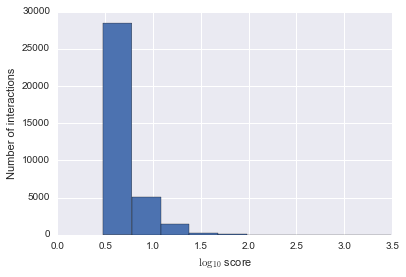

In [7]:
np.log10(se).hist()
plt.ylabel('Number of interactions')
plt.xlabel('$\log_{10}$ score');

I'm guessing the score is high for more confident interactions. I can look through the
methods to verify this.

From the paper:
    
    There were 12,987 CTCF-CTCF loops in naive hESCs, encompassing 37% of the genome and 33% of protein-coding genes (Table S3).

In [8]:
interactions[interactions.columns[-2]].sum()

12987

We can see that the second to last column identifies things that are loops in naive hESCs
but are not at enhancers or promoters. We can see that the columns

    CTCF-CTCF loops (not at enhancers or promoters)
    CTCF-CTCF loops (putative insulated neighborhoods)
    
are subsets of

    CTCF-CTCF loops

In [9]:
interactions[(interactions[interactions.columns[-3]] == False) & 
             (interactions[interactions.columns[-2]] == True)].shape

(0, 11)

In [10]:
interactions[(interactions[interactions.columns[-3]] == False) & 
             (interactions[interactions.columns[-1]] == True)].shape

(0, 11)

However the last column is not a subset of the second to last column:

In [11]:
interactions[(interactions['CTCF-CTCF loops (not at enhancers or promoters)'] == True) & 
             (interactions['CTCF-CTCF loops (putative insulated neighborhoods)'] == True)].shape

(6183, 11)

In [12]:
interactions[interactions.columns[-3:]].sum()

CTCF-CTCF loops                                       21953
CTCF-CTCF loops (not at enhancers or promoters)       12987
CTCF-CTCF loops (putative insulated neighborhoods)     9344
dtype: int64

So now the question is what to the last three columns mean. I believe 
the `CTCF-CTCF loops` column is `True` for any interaction where there are 
CTCF peaks and motifs in each interaction peak and the CTCF motifs 
are arranged in the expected convergent orientation. These are loops.

I think the `CTCF-CTCF loops (not at enhancers or promoters)` is `False` 
for any interaction where at least one of the interaction peaks overlaps either
a promoter ("promoter regions that are defined as +/- 2 kb of the Refseq TSS")
or an enhancer (defined by the H3k27ac peaks) based on this from the methods:

    Operationally, an interaction was defined as associated with the regulatory element if one of the two PET peaks of the interaction overlapped with the regulatory element by at least 1 base pair.
    
The insulated neighborhoods were defined according to a computational method
but the basic idea is that interactions upstream or downsream of the loop 
should not interact with regions inside of the loop. We can see that of the 12,987
CTCF loops that are not promoter/enhancer loops, 6,183 are insulated neighborhoods.

Let's look at some of the insulated neighborhoods from one peak to the other.

In [13]:
t = interactions[interactions['CTCF-CTCF loops (putative insulated neighborhoods)']]
t = t[t.Chr_1 == t.Chr_2]
mi = t.apply(lambda x: min(x['End_1'], x['End_1']), axis=1)
ma = t.apply(lambda x: max(x['Start_1'], x['Start_2']), axis=1)
s = '\n'.join(t.Chr_1 + '\t' + mi.astype(str) + '\t' + ma.astype(str)) + '\n'
bt = pbt.BedTool(s, from_string=True)
bt = bt.sort()
bt_merged = bt.merge()
bt.head()

chr1	1876387	1975584
 chr1	1892659	1975584
 chr1	2127461	2312590
 chr1	2346712	2477085
 chr1	2929886	3200057
 chr1	2929886	3340656
 chr1	3401518	3534941
 chr1	3408807	3531141
 chr1	3408807	3534941
 chr1	4717302	4885718
 

In [14]:
res = bt_merged.intersect(bt, sorted=True, wo=True)
count = 0
for r in res:
    if int(r[1]) < int(r[4]) and int(r[2]) > int(r[5]):
        count += 1
print(count)

2051


We can see that insulated neighborhoods can share one end but differ on the other end:

    chr1	3408807	3531141
    chr1	3408807	3534941
    
There are also some insulated neighborhoods which are completely contained within other 
insulated neighborhoods.

### Interaction sizes

Let's look at the interactions a bit more. Here are the sizes 
of the first and second peaks:

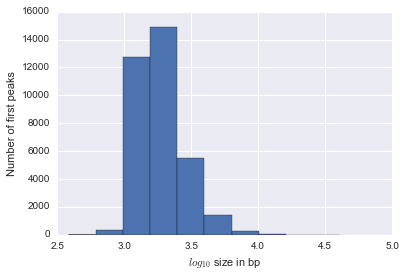

In [15]:
se = interactions.End_1 - interactions.Start_1
np.log10(se.abs()).hist()
plt.ylabel('Number of first peaks')
plt.xlabel('$log_{10}$ size in bp');

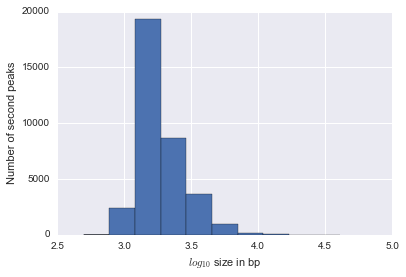

In [16]:
se = interactions.End_2 - interactions.Start_2
np.log10(se.abs()).hist()
plt.ylabel('Number of second peaks')
plt.xlabel('$log_{10}$ size in bp');

The paper says:

    There were 12,987 CTCF-CTCF loops in naive hESCs, encompassing 37% of the genome and 33% of protein-coding genes (Table S3). These CTCF-CTCF loops ranged from 4 to >800 kb and contained 0–24 protein-coding genes, with a median of 200 kb and one protein-coding gene per loop. 

After talking to Xiong Ji, it seems that the 200 kb size comes from the insulated neighborhoods.

Here's the plot including the peaks:

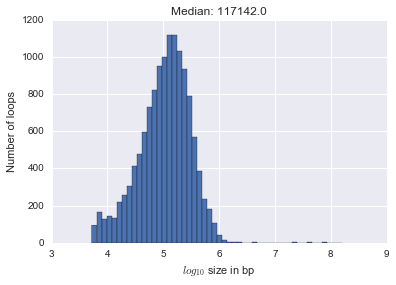

In [17]:
mi = interactions[interactions['CTCF-CTCF loops (not at enhancers or promoters)']].apply(
    lambda x: min(x['Start_1'], x['Start_2']), axis=1)
ma = interactions[interactions['CTCF-CTCF loops (not at enhancers or promoters)']].apply(
    lambda x: max(x['End_1'], x['End_2']), axis=1)
se = ma - mi
np.log10(se.abs()).hist(bins=50)
plt.ylabel('Number of loops')
plt.xlabel('$log_{10}$ size in bp')
plt.title('Median: {}'.format(se.median()));

Here's the plot not including the peaks:

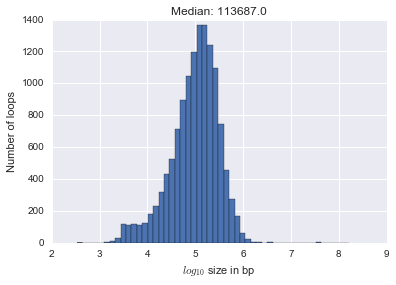

In [19]:
mi = interactions[interactions['CTCF-CTCF loops (not at enhancers or promoters)']].apply(
    lambda x: min(x['End_1'], x['End_1']), axis=1)
ma = interactions[interactions['CTCF-CTCF loops (not at enhancers or promoters)']].apply(
    lambda x: max(x['Start_1'], x['Start_2']), axis=1)
se = ma - mi
np.log10(se.abs()).hist(bins=50)
plt.ylabel('Number of loops')
plt.xlabel('$log_{10}$ size in bp')
plt.title('Median: {}'.format(se.median()));

These medians are closer to 100kb than 200kb.

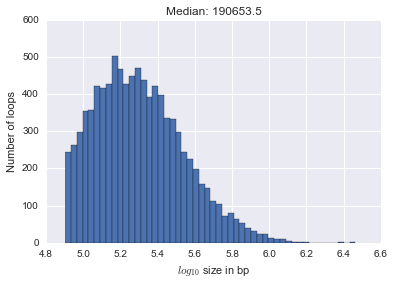

In [20]:
mi = interactions[interactions['CTCF-CTCF loops (putative insulated neighborhoods)']].apply(
    lambda x: min(x['Start_1'], x['Start_2']), axis=1)
ma = interactions[interactions['CTCF-CTCF loops (putative insulated neighborhoods)']].apply(
    lambda x: max(x['End_1'], x['End_2']), axis=1)
se = ma - mi
np.log10(se.abs()).hist(bins=50)
plt.ylabel('Number of loops')
plt.xlabel('$log_{10}$ size in bp')
plt.title('Median: {}'.format(se.median()));

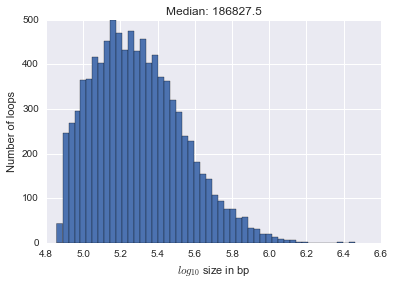

In [21]:
mi = interactions[interactions['CTCF-CTCF loops (putative insulated neighborhoods)']].apply(
    lambda x: min(x['End_1'], x['End_1']), axis=1)
ma = interactions[interactions['CTCF-CTCF loops (putative insulated neighborhoods)']].apply(
    lambda x: max(x['Start_1'], x['Start_2']), axis=1)
se = ma - mi
np.log10(se.abs()).hist(bins=50)
plt.ylabel('Number of loops')
plt.xlabel('$log_{10}$ size in bp')
plt.title('Median: {}'.format(se.median()));

The median is closer to 200kb for insulated neighborhoods.

The last column `CTCF-CTCF loops (putative insulated neighborhoods)` identifies
loops that are "insulated neighborhoods." From the paper:

    If the CTCF-CTCF loops identified in hESC function as insulated neighborhoods, we expect that most cohesin-associated interactions with an endpoint inside the loop have their other endpoint within the loop.
    
So an insulated neighborhood basically means that interactions that have a peak within a loop have 
their other peak in the loop as well.

## Interactions parsing and annotation

I'm going to annotate these interactions to make them more useful.
I'm going to annotate

* whether the interaction is interchromosomal
* whether each peak overlaps CTCF, H3K27ac, promoter (for which genes(s)), super-enhancer
* genes contained within loop

Let's start by renaming the columns to be more friendly and annotating inter- vs. intra- chromosomal.

In [23]:
interactions.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'ID',
                        'score', 'ctcf_loop', 'nep_loop', 'pin_loop']
interactions['intra'] = True
interactions.ix[interactions.chrom1 != interactions.chrom2, 'intra'] = False

I'll add in names (chr:start-end)
for the peaks and the entire loop as well as the loop coordinates (`start1` is not always less
than `start2` etc.) I'll also make a bed file for the loops. Some of this will be limited
to intrachromosomal interactions.

In [24]:
interactions['peak1'] = (interactions.chrom1 + ':' + 
                         interactions.start1.astype(str) + '-' + 
                         interactions.end1.astype(str))
interactions['peak2'] = (interactions.chrom2 + ':' + 
                         interactions.start2.astype(str) + '-' + 
                         interactions.end2.astype(str))

tdf = interactions[interactions.intra]
loops = (tdf.chrom1 + ':' + tdf.apply(lambda x: x[['start1', 'start2']].min(), axis=1).astype(str) + 
         '-' + tdf.apply(lambda x: x[['end1', 'end2']].max(), axis=1).astype(str))
loops_inner = (tdf.chrom1 + ':' + tdf.apply(lambda x: x[['end1', 'end2']].min(), axis=1).astype(str) + 
               '-' + tdf.apply(lambda x: x[['start1', 'start2']].max(), axis=1).astype(str))

s = '\n'.join(loops.apply(lambda x: x.replace(':', '\t').replace('-', '\t'))) + '\n'
loops_bt = pbt.BedTool(s, from_string=True).sort()
loops_bt.saveas(os.path.join(outdir, 'loops.bt'))
s = '\n'.join(loops_inner.apply(lambda x: x.replace(':', '\t').replace('-', '\t'))) + '\n'
loops_inner_bt = pbt.BedTool(s, from_string=True).sort()
loops_inner_bt.saveas(os.path.join(outdir, 'loops_inner.bt'))

interactions['loop'] = np.nan
interactions.ix[tdf.index, 'loop'] = loops
interactions['loop_inner'] = np.nan
interactions.ix[tdf.index, 'loop_inner'] = loops_inner

I'll make a bed file for the ChIA-PET peaks so I can work with those.

In [25]:
s = '\n'.join(interactions.chrom1 + '\t' + interactions.start1.astype(str) + 
              '\t' + interactions.end1.astype(str)) + '\n'
s += '\n'.join(interactions.chrom2 + '\t' + interactions.start2.astype(str) + 
               '\t' + interactions.end2.astype(str)) + '\n'
chia_peaks = pbt.BedTool(s, from_string=True).sort().merge()
chia_peaks.saveas(os.path.join(outdir, 'chia_peaks.bed'))

<BedTool(/frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/ji_et_al_2015_processing/chia_peaks.bed)>

Now let's annotate the ChIA-PET peaks with CTCF and H3K27ac. We have some 
information about this from the last column, but we don't know which exact
peaks overlap these features.

In [26]:
def annotate_chia_peaks(bt, name):
    res = chia_peaks.intersect(bt, sorted=True, wo=True)
    tdf = res.to_dataframe()
    tdf.index = (tdf.chrom + ':' + tdf.start.astype(str) +
                 '-' + tdf.end.astype(str))
    tdf[name] = (tdf.name + ':' + tdf.score.astype(str) +
                 '-' + tdf.strand.astype(str))
    interactions.index = interactions.peak1
    interactions['{}1'.format(name)] = False
    ind = set(tdf.index) & set(interactions.index)
    interactions.ix[ind, '{}1'.format(name)] = True
    interactions.index = interactions.peak2
    interactions['{}2'.format(name)] = False
    ind = set(tdf.index) & set(interactions.index)
    interactions.ix[ind, '{}2'.format(name)] = True
    annot = {}
    for r in res:
        i = '{}:{}-{}'.format(r.chrom, r.start, r.end)
        v = '{}:{}-{}'.format(r.name, r.score, r.strand)
        annot[i] = annot.get(i, set()) | set([v])
    annot = pd.Series(annot)
    annot.to_pickle(os.path.join(outdir, 'chia_to_{}.pickle'.format(name)))
    interactions.index = range(interactions.shape[0])
    return interactions

In [27]:
interactions = annotate_chia_peaks(ctcf_bt, 'ctcf')
interactions = annotate_chia_peaks(enh_bt, 'h3k27ac')

Now let's annotate whether ChIA-PET peaks overlap promoters, exons,
or gene bodies. We'll also annotate which genes are contained in a loop.

In [28]:
def annotate_chia_peaks(bt, name, use_name_col=False):
    res = chia_peaks.intersect(bt, sorted=True, wo=True)
    tdf = res.to_dataframe()
    tdf.index = (tdf.chrom + ':' + tdf.start.astype(str) +
                 '-' + tdf.end.astype(str))
    tdf[name] = (tdf.name + ':' + tdf.score.astype(str) +
                 '-' + tdf.strand.astype(str))
    interactions.index = interactions.peak1
    interactions['{}1'.format(name)] = False
    ind = set(tdf.index) & set(interactions.index)
    interactions.ix[ind, '{}1'.format(name)] = True
    interactions.index = interactions.peak2
    interactions['{}2'.format(name)] = False
    ind = set(tdf.index) & set(interactions.index)
    interactions.ix[ind, '{}2'.format(name)] = True
    annot = {}
    for r in res:
        i = '{}:{}-{}'.format(r.chrom, r.start, r.end)
        if use_name_col:
            v = r.fields[6]
        else:
            v = '{}:{}-{}'.format(r.name, r.score, r.strand)
        annot[i] = annot.get(i, set()) | set([v])
    annot = pd.Series(annot)
    annot.to_pickle(os.path.join(outdir, 'chia_to_{}.pickle'.format(name)))
    interactions.index = range(interactions.shape[0])
    return interactions

In [39]:
interactions = annotate_chia_peaks(promoters, 'promoter', use_name_col=True)
interactions = annotate_chia_peaks(exons, 'exon', use_name_col=True)
interactions = annotate_chia_peaks(genes, 'gene', use_name_col=True)

# I'll parse the peak to promoter and exon mappings for these so they are gene IDs.
t = pd.read_pickle(os.path.join(outdir, 'chia_to_promoter.pickle'))
t = t.apply(lambda x: set([y.split('_')[0] for y in x]))
t.to_pickle(os.path.join(outdir, 'chia_to_promoter_gene.pickle'))
t = pd.read_pickle(os.path.join(outdir, 'chia_to_exon.pickle'))
t = t.apply(lambda x: set([transcript_to_gene[y.split('_')[0]] for y in x]))
t.to_pickle(os.path.join(outdir, 'chia_to_exon_gene.pickle'))

Now I'll find which genes are contained within loops. I'll go ahead and do this 
for all interactions but it's probably only meaningful for loops.

In [70]:
s = '\n'.join(interactions[interactions.intra].loop.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
bt = pbt.BedTool(s, from_string=True)
bt = bt.sort()
res = bt.intersect(genes, wo=True, sorted=True)

In [71]:
interaction_contains = {}
interaction_partially_contains = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    if int(r.fields[5]) - int(r.fields[4]) == int(r.fields[-1]):
        interaction_contains[ind] = interaction_contains.get(ind, []) + [r.fields[6]]
    else:
        interaction_partially_contains[ind] = interaction_partially_contains.get(ind, []) + [r.fields[6]]
interaction_contains = pd.Series(interaction_contains)
interaction_contains.to_pickle(os.path.join(outdir, 'interaction_contains_gene.pickle'))
interaction_partially_contains = pd.Series(interaction_partially_contains)
interaction_partially_contains.to_pickle(os.path.join(outdir, 'interaction_partially_contains_gene.pickle'))

In [82]:
gene_to_containing_interactions = {}
for i in interaction_contains.index:
    for g in interaction_contains[i]:
        gene_to_containing_interactions[g] = gene_to_containing_interactions.get(g, set()) | set([i])
gene_to_containing_interactions = pd.Series(gene_to_containing_interactions)
gene_to_containing_interactions.to_pickle(
    os.path.join(outdir, 'gene_to_containing_interactions.pickle'))

In [76]:
interactions.to_csv(os.path.join(outdir, 'interactions.tsv'), sep='\t', index=None)